# Photochemistry with Photochem

Gas-rich exoplanets (e.g., warm Jupiters or mini-Neptunes) often have an atmospheric composition that is out of chemical equilibrium. As gases mix from high pressures and temperature to the cooler upper atmosphere, reactions slow and can ultimately stop, failing to maintain equilibrium. Also, UV photolysis and subsequent chemical reactions can also drive disequilibrium chemistry.

In this tutorial you will learn the basics of simulating disequilibrium chemistry in a gas-rich exoplanet's atmosphere with the [Photochem](https://github.com/Nicholaswogan/photochem) code ([Wogan et al. 2023](https://doi.org/10.3847/PSJ/aced83)). Specifically, this tutorial broadly reproduces the photochemical SO$_2$ in WASP-39b's atmosphere as described in [Tsai et al. (2023)](https://doi.org/10.1038/s41586-023-05902-2) and computes the resulting transmission spectrum with Picaso.

<!--

For example, at depth in a gas-rich atmosphere (e.g., 1000 bar), the atmosphere is often hot and chemical reactions are fast, enforcing chemical equilibrium. But, as gases mix upward, chemical reactions can slow, and ultimately stop "freezing-out"


`Photochem` captures disequilibrium effects by tracking hundreds of elementary chemical reactions like,



$$\mathrm{H_2} + \mathrm{OH} \leftrightarrow \mathrm{H_2O} + \mathrm{H}$$

Each reaction has a rate constant derived experimentally or from Ab initio calculations that can depend on temperature and pressure. Reactions are often faster with increased temperature and pressure. In `Photochem`, all reactions (except photolysis reactions) are reversed using thermodynamic principles. This means that the chemical network will predict chemical equilibrium at high temperatures and pressures, and deviate from equilibrium at cooler temperatures and when UV photolysis is important. UV photons from a host star can split molecules apart (e.g., $\mathrm{H_2O} + h\nu \rightarrow \mathrm{OH} + \mathrm{H}$) in the upper atmosphere, and ultimately drive further chemistry. -->

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 13})
from IPython.display import clear_output
from astropy import constants

class WASP39b:
    planet_radius = 1.279 # Jupiter radii
    planet_mass = 0.28 # Jupiter masses
    planet_Teq = 1166 # Equilibrium temp (K)
    stellar_radius = 0.932 # Solar radii
    stellar_Teff = 5400 # K
    stellar_metal = 0.01 # log10(metallicity)
    stellar_logg = 4.45 # log10(gravity), in cgs units

## Installing Photochem

For this tutorial to work, you must install Photochem with conda: `conda install -c conda-forge photochem=0.6.7`

## Choosing a UV stellar spectrum

To run `photochem`, we need a stellar spectrum that includes the UV. For other spectral applications, Picaso often makes use of the "phoenix" or "ck04models" stellar models. But neither of these stellar spectra characterize the UV. The best alternative is the [MUSCLES](https://archive.stsci.edu/prepds/muscles/) database of spectra. Photochem has some utilities for downloading MUSCLES spectra:

In [2]:
from photochem.utils import stars

stars.print_muscles_stars()

GJ1132: {st_logg: 5.04, st_met: -0.17, st_rad: 0.22, st_teff: 3229.0}
GJ1214: {st_logg: 5.03, st_met: 0.24, st_rad: 0.22, st_teff: 3101.0}
GJ15A: {st_logg: 4.89, st_met: -0.391, st_rad: 0.38, st_teff: 3742.67}
GJ163: {st_logg: 4.82, st_met: 0.1, st_rad: 0.41, st_teff: 3399.0}
GJ176: {st_logg: 4.78, st_met: 0.147, st_rad: 0.48, st_teff: 3703.49}
GJ436: {st_logg: 4.84, st_met: 0.099, st_rad: 0.42, st_teff: 3586.11}
GJ551: {st_logg: 5.16, st_met: null, st_rad: 0.14, st_teff: 2900.0}
GJ581: {st_logg: 4.94, st_met: -0.088, st_rad: 0.32, st_teff: 3490.39}
GJ649: {st_logg: 4.76, st_met: -0.15, st_rad: 0.5, st_teff: 3734.0}
GJ667C: {st_logg: 4.69, st_met: -0.55, st_rad: null, st_teff: 3650.0}
GJ674: {st_logg: 4.86, st_met: -0.28, st_rad: 0.36, st_teff: 3451.0}
GJ676A: {st_logg: 4.62, st_met: 0.08, st_rad: 0.69, st_teff: 3734.0}
GJ699: {st_logg: 4.9, st_met: -0.56, st_rad: 0.18, st_teff: 3195.0}
GJ729: {st_logg: null, st_met: null, st_rad: null, st_teff: 3240.0}
GJ832: {st_logg: 4.7, st_met: -0

TOI-193 appears to have the closest effective temperature to WASP-39, so we will use it's spectrum. The cell below downloads the spectrum from MUSCLES, rescales the spectrum so it has the bolometric flux appropriate for WASP-39b, then saves it to a file format that photochem will later read.

In [3]:
wv, F = stars.muscles_spectrum(
    'TOI-193',
    outputfile='TOI-193.txt',
    Teq=WASP39b.planet_Teq
)

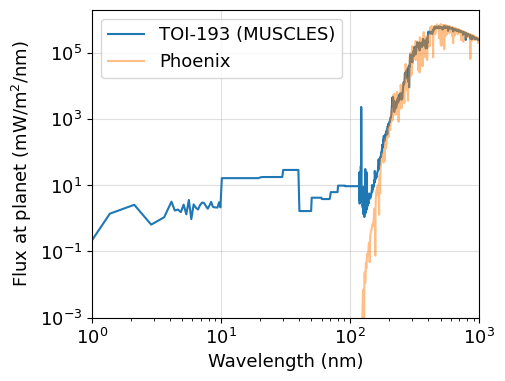

In [4]:
fig,ax = plt.subplots(1,1,figsize=[5,4])

# Plot the spectrum
ax.plot(wv, F, label='TOI-193 (MUSCLES)')

# Phoenix spectrum
import stsynphot as sts
import astropy.units as u
ST_SS = sts.grid_to_spec('phoenix', 5480, 0.25, 4.47)
wave_star = (ST_SS.waveset).to(u.nm).value
flux_star = ST_SS(ST_SS.waveset,flux_unit=u.Unit('erg*cm^(-2)*s^(-1)*AA^(-1)')).value

factor = stars.equilibrium_temperature_inverse(WASP39b.planet_Teq, 0.0)/stars.energy_in_spectrum(wave_star, flux_star)
ax.plot(wave_star, flux_star*factor, alpha=0.5, label='Phoenix')

ax.set_ylabel('Flux at planet (mW/m$^2$/nm)')
ax.set_xlabel('Wavelength (nm)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3,2e6)
ax.set_xlim(1,1000)
ax.grid(alpha=0.4)
ax.legend()

plt.show()

The plot above clearly shows how the phoenix model fails to capture the UV.

## Choosing a reaction network

To run photochem, we also need a network of chemical reactions and thermodynamic data. We can accomplish this with the function `zahnle_rx_and_thermo_files`, which starts with the main reaction file shipped with photochem and the trims out some unnecessary chemistry. Running this next cell produces two files: `photochem_rxns.yaml` for photochemistry/kinetics and `photochem_thermo.yaml` for equilibrium chemistry calculations.

In [5]:
from photochem.utils import zahnle_rx_and_thermo_files

zahnle_rx_and_thermo_files(
    atoms_names=['H', 'He', 'N', 'O', 'C', 'S'], # We select a subset of the atoms in zahnle_earth.yaml (leave out Cl)
    rxns_filename='photochem_rxns.yaml',
    thermo_filename='photochem_thermo.yaml',
    remove_reaction_particles=True # For gas giants, we should always leave out reaction particles.
)

Note, fast chemistry can sometimes slow down or prevent the photochemical model from reaching a steady state. Sulfur chemistry in particular, is often problematic, but mostly for cooler planets than WASP-39b. If you have troubles reaching convergence, then perhaps remove "S3", "S4", "S8", and "S8aer", if these species are not extremely important:

```python
zahnle_rx_and_thermo_files(
    atoms_names=['H', 'He', 'N', 'O', 'C', 'S'],
    rxns_filename='photochem_rxns.yaml',
    thermo_filename='photochem_thermo.yaml',
    exclude_species=['S3','S4','S8','S8aer'],
    remove_reaction_particles=True
)
```

If you don't care about sulfur species at all, then just omit "S" from `atoms_names`

```python
zahnle_rx_and_thermo_files(
    atoms_names=['H', 'He', 'N', 'O', 'C'],
    rxns_filename='photochem_rxns.yaml',
    thermo_filename='photochem_thermo.yaml',
    remove_reaction_particles=True
)
```

It is possible to use reaction networks besides the ones shipped with photochem. For example, photochem has the function `vulcan2yaml` (import with `from photochem.utils import vulcan2yaml`), which allows Photochem to use [VULCAN](https://github.com/exoclime/VULCAN) chemical networks.

## Initializing the photochemical model

Next, we initialize the gas giant extension to `photochem`, called `EvoAtmosphereGasGiant`.

In [6]:
from photochem.extensions import gasgiants

pc = gasgiants.EvoAtmosphereGasGiant(
    'photochem_rxns.yaml',
    'TOI-193.txt',
    planet_mass=WASP39b.planet_mass*constants.M_jup.cgs.value,
    planet_radius=WASP39b.planet_radius*constants.R_jup.cgs.value,
    solar_zenith_angle=83, # Used in Tsai et al. (2023). By default, 60.
    thermo_file='photochem_thermo.yaml'
)
pc.gdat.verbose = False # No printing
# The diurnal averaging factor. This is normally 0.5 for a global average,
# but we use 1 to follow Tsai et al. (2023).
pc.var.diurnal_fac = 1.0

When modeling a gas giant, researchers often assume the planet has some composition relative to the Sun (i.e., a metallicity). The `EvoAtmosphereGasGiant` extension has a `ChemEquiAnalysis` object attached to it (`pc.gdat.gas`, see `from photochem.equilibrate import ChemEquiAnalysis` for details) for doing equilibrium chemistry calculations at depth in the gas giant atmosphere. This object contains an estimated composition of the Sun:

In [7]:
for i,atom in enumerate(pc.gdat.gas.atoms_names):
    print('%s %.2e'%(atom,pc.gdat.gas.molfracs_atoms_sun[i]))

H 9.21e-01
N 6.23e-05
O 4.51e-04
C 2.48e-04
S 1.21e-05
He 7.84e-02


The above solar composition is very reasonable, but below we change to the exact solar composition in Tsai et al. (2023) to best reproduce their results.

In [8]:
molfracs_atoms_sun = np.ones(len(pc.gdat.gas.atoms_names))*1e-10
comp = {
    'O': 5.37E-4,
    'C': 2.95E-4,
    'N': 7.08E-5,
    'S': 1.41E-5,
    'He': 0.0838,
    'H': 1
}
tot = sum(comp.values())
for key in comp:
    comp[key] /= tot
for i,atom in enumerate(pc.gdat.gas.atoms_names):
    molfracs_atoms_sun[i] = comp[atom]

pc.gdat.gas.molfracs_atoms_sun = molfracs_atoms_sun

Next, we establish several key variables
- The Pressure-Temperature profile. Here, we use the "morning" profile described in Tsai et al. (2023), computed with a GCM.
- The $K_{zz}$ profile (i.e., eddy diffusion). Here, we use the same values as Tsai et al. (2023).
- The metallicity. Like in Tsai et al. (2023), we assume a 10x solar value.
- The C/O ratio. Following Tsai et al. (2023), we assume the solar ratio.

In [9]:
# The "Morning" P-T profile from a GCM in Tsai et al. (2023)
P = np.array([1.816e+08, 1.222e+08, 8.216e+07, 5.526e+07, 3.717e+07, 2.500e+07,
       1.682e+07, 1.131e+07, 7.607e+06, 5.117e+06, 3.441e+06, 2.315e+06,
       1.557e+06, 1.047e+06, 7.044e+05, 4.738e+05, 3.187e+05, 2.144e+05,
       1.442e+05, 9.702e+04, 6.527e+04, 4.392e+04, 2.956e+04, 1.990e+04,
       1.340e+04, 9.030e+03, 6.089e+03, 4.111e+03, 2.779e+03, 1.883e+03,
       1.280e+03, 8.735e+02, 5.995e+02, 4.146e+02, 2.896e+02, 2.050e+02,
       1.474e+02, 1.081e+02, 8.098e+01, 6.216e+01, 4.889e+01, 3.935e+01,
       3.233e+01, 2.700e+01, 2.281e+01, 1.939e+01, 1.648e+01, 1.392e+01,
       1.159e+01, 9.421e+00, 7.352e+00, 5.349e+00]) # dynes/cm^2
T = np.array([4503.4, 4190.6, 3886. , 3589.6, 3302.8, 3028.7, 2766. , 2505.9,
       2246.5, 2024.9, 1853.3, 1725.7, 1640.7, 1576.9, 1518.7, 1453.3,
       1385.2, 1318.5, 1249. , 1180.7, 1117.8, 1061.5, 1010.1,  959.2,
        909.3,  864.8,  824.3,  789.8,  759. ,  734.6,  714.9,  701.3,
        691.3,  686.4,  687.8,  696.3,  709.1,  723.8,  737.4,  747.2,
        754.9,  761. ,  765.3,  767.1,  767.2,  764.8,  761.3,  755. ,
        746.8,  734.7,  720.2,  703.4])

# Assumed Kzz (cm^2/s) in Tsai et al. (2023)
Kzz = np.ones(P.shape[0])
for i in range(P.shape[0]):
    if P[i]/1e6 > 5.0:
        Kzz[i] = 5e7
    else:
        Kzz[i] = 5e7*(5/(P[i]/1e6))**0.5

metallicity = 10.0 # 10x solar
CtoO = 1.0 # 1x solar

With these key values set, we can call `initialize_to_climate_equilibrium_PT`. This predicts an starting guess for the atmospheric composition using chemical equilibrium. The routine then builds an altitude grid for the photochemical model based on this initial chemistry.

In [10]:
pc.initialize_to_climate_equilibrium_PT(P, T, Kzz, metallicity, CtoO)

## Integrating the photochemistry to a steady-state

We can now integrate to a photochemical steady state. This can be most easily accomplished by calling `pc.find_steady_state()`, but below we instead integrate one step at a time, plotting the atmosphere as it evolves.

In [11]:
pc.initialize_robust_stepper(pc.wrk.usol)

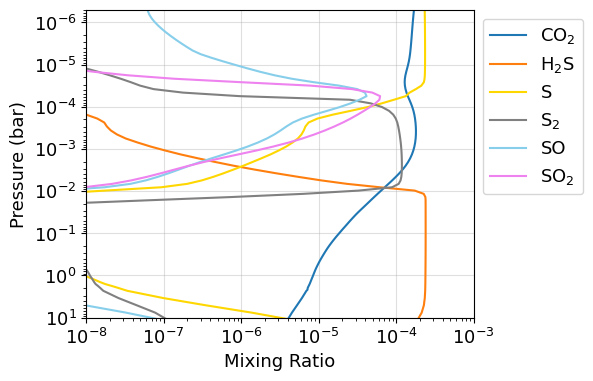

In [12]:
while True:

    # Plot the atmosphere
    clear_output(wait=True)
    fig,ax = plt.subplots(1,1,figsize=[5,4])
    fig.patch.set_facecolor("w")

    sol = pc.return_atmosphere()
    soleq = pc.return_atmosphere(equilibrium=True)

    species = ['CO2','H2S','S','S2','SO','SO2']
    names = ['CO$_2$','H$_2$S','S','S$_2$','SO','SO$_2$']
    colors = ['C0','C1','gold','grey','skyblue','violet']
    for i,sp in enumerate(species):
        ax.plot(sol[sp],sol['pressure']/1e6,label=names[i],c=colors[i])
        # ax.plot(soleq[sp],soleq['pressure']/1e6,c=colors[i], ls=':', alpha=0.4)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-8,1e-3)
    ax.set_ylim(10,5e-7)
    ax.grid(alpha=0.4)
    ax.legend(ncol=1,bbox_to_anchor=(1,1.0),loc='upper left')
    ax.set_xlabel('Mixing Ratio')
    ax.set_ylabel('Pressure (bar)')
    ax.set_yticks(10.0**np.arange(-6,2))
    plt.show()

    # break

    for i in range(100):
        give_up, reached_steady_state = pc.robust_step()
        if give_up or reached_steady_state:
            break
    if give_up or reached_steady_state:
        break

The plot broadly reproduces Fig. 1a in Tsai et al. (2023). Here, we do not use the exact same stellar spectrum as Tsai et al. (2023), so some differences are expected.

## Computing the transmission spectrum with Picaso

Now, we can export this composition and climate to Picaso, to compute its transmission spectrum.

In [13]:
from picaso import justdoit as jdi
import os
import pandas as pd

# For creating a Picaso input from Photochem
def create_picaso_atm(pc):
    sol = pc.return_atmosphere()
    del sol['Kzz']
    sol['pressure'] /= 1e6 # convert to bars
    atm = {}
    for key in sol:
        if key in ['pressure', 'temperature'] or 'aer' not in key:
            atm[key] = sol[key][::-1].copy()
    return pd.DataFrame(atm)

The cell below grabs some opacities, initializes the Picaso `inputs` class, and sets the gravity and stellar spectrum.

In [14]:
opa = jdi.opannection(wave_range=[2,5.5])

case = jdi.inputs()

case.gravity(
    mass=WASP39b.planet_mass,
    mass_unit=jdi.u.Unit('M_jup'),
    radius=WASP39b.planet_radius,
    radius_unit=jdi.u.Unit('R_jup')
)

case.star(
    opa,
    temp=WASP39b.stellar_Teff,
    metal=WASP39b.stellar_metal,
    logg=WASP39b.stellar_logg,
    radius=WASP39b.stellar_radius,
    radius_unit=jdi.u.Unit('R_sun')
)

Below is a little helper function for computing spectra with different inputs, then downbinning the spectra to lower resolution.

In [15]:
def spectrum(opa, case, atm, R=100, atmosphere_kwargs={}):

    # Set atmosphere
    case.atmosphere(atm, verbose=False, **atmosphere_kwargs)

    # Compute spectrum
    df = case.spectrum(opa, calculation='transmission')

    # Extract spectrum
    wv_h = 1e4/df['wavenumber'][::-1].copy()
    wavl_h = stars.make_bins(wv_h)
    rprs2_h = df['transit_depth'][::-1].copy()

    # Rebin
    wavl = stars.grid_at_resolution(np.min(wavl_h), np.max(wavl_h), R)
    rprs2 = stars.rebin(wavl_h.copy(), rprs2_h.copy(), wavl.copy())

    return wavl, rprs2

Finally, we compute the transmission spectrum several times leaving out important molecules (e.g., SO$_2$), to show their impact on the spectrum:

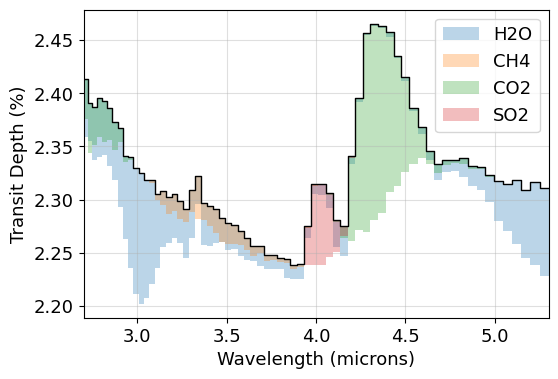

In [16]:
fig,ax = plt.subplots(1,1,figsize=[6,4])

# Create Picaso atmosphere from Photochem object
atm = create_picaso_atm(pc)

# Compute and plot spectrum
wavl, rprs2 = spectrum(opa, case, atm, R=100)
ax.plot(wavl[1:], rprs2*1e2, drawstyle='steps-pre', lw=1, c='k')

# Compute the spectrum several more times, to show the impact of different species.
species = ['H2O','CH4','CO2','SO2']
for sp in species:
    _, rprs2_1 = spectrum(opa, case, atm, R=100, atmosphere_kwargs={'exclude_mol':[sp]})
    ax.fill_between(wavl[1:], rprs2*1e2, rprs2_1*1e2, step='pre', label=sp, alpha=0.3)

ax.set_xlim(2.7,5.3)
ax.set_ylabel('Transit Depth (%)')
ax.set_xlabel('Wavelength (microns)')
ax.grid(alpha=0.4)
ax.legend()
plt.show()

The plot above is similar to Figure 3b in Tsai et al. (2023). Note, however, that Tsai et al. (2023) took a slightly different approach for computing WASP-39b's transmission spectrum. They did two 1-D photochemical calculations, one each for the morning and evening terminator. They then computed the transmission spectrum of both results, and averaged them to produce Fig. 3b. For simplicity, in this tutorial, we only computed the photochemistry & spectrum of the morning terminator.